group 5 assignement: future forecast model and metrics performance

In [258]:
# import libs
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.tools.eval_measures import rmse

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
#from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix




In [259]:
# the data were copied from part 2 of the project

#sales_dirty_df = pd.read_csv(filepath_or_buffer='sales_train_v2.csv', sep=',')
sales_train_df = pd.read_csv('sales_train_v2.csv', sep=',',header=0,parse_dates=True)

shops_df = pd.read_csv('shops.csv', sep=',',header=0)
item_category_df = pd.read_csv('item_categories.csv', sep=',',header=0)
items_df = pd.read_csv('items.csv', sep=',',header=0)
test_df = pd.read_csv('test.csv', sep=',',header=0)


In [260]:
# View info()
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [262]:
# Split the date into day, month and year to facilitate deeper interpretation.

raw_date = sales_train_df.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

sales_train_df['day'] = raw_date.dt.day
sales_train_df['month'] = raw_date.dt.month
sales_train_df['year'] = raw_date.dt.year

#sales_train_df.head()

In [265]:
# calculate the sales store per month
sales_train_df['sales']=sales_train_df.item_price*sales_train_df.item_cnt_day

In [267]:
# Add item category to the sales train dataset
sales_train_df = pd.merge(sales_train_df,items_df, on='item_id')
sales_train_df.drop('item_name', axis=1,inplace=True)

In [268]:
new_sales_train=sales_train_df
new_sales_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,sales,item_category_id_x,item_category_id_y,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,2,1,2013,999.0,37,37,37
1,23.01.2013,0,24,22154,999.0,1.0,23,1,2013,999.0,37,37,37
2,20.01.2013,0,27,22154,999.0,1.0,20,1,2013,999.0,37,37,37


In [372]:
# preparing the series for the model
df2 = pd.DataFrame(new_sales_train,columns=['date','sales'])
# convert column date to datetime
df2['date'] = df2['date'].astype('datetime64[ns]')
df2.index = df2.date
#removing null values
df2['sales'] = df2['sales'].fillna(0)
df2 = df2.resample('M').mean()

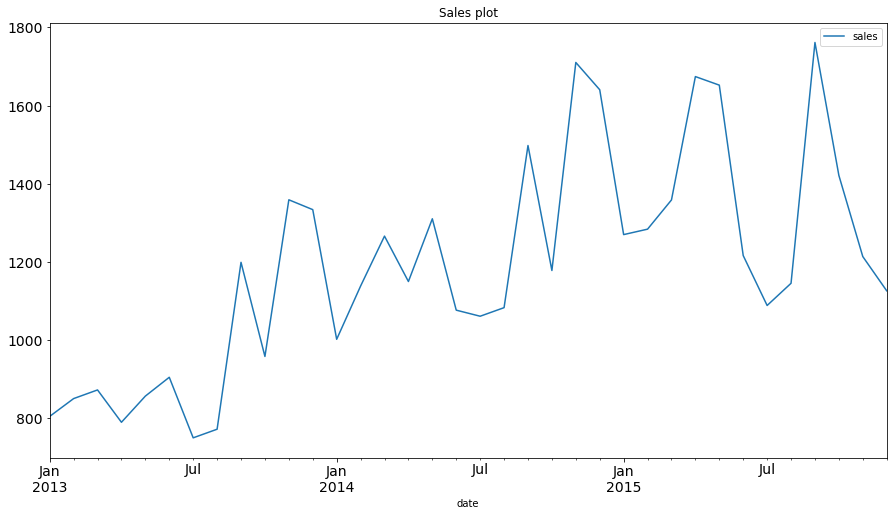

In [373]:
df2.plot(figsize=(15,8), title= 'Sales plot', fontsize=14)
plt.show()
# observation: we can see that the sales is steady throughout the year but has some peaks before January, july

In [374]:
# Check for other odd value due to dicky fuller NAN values 
df2['sales'] = df2['sales'].fillna(0)
df2[df2['sales'].isin([np.nan, np.inf, -np.inf])]

,sales
date,


C:\Users\benia\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
C:\Users\benia\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1350: RuntimeWarning: invalid value encountered in double_scalars
  r[k] = (X[0:-k] * X[k:]).sum() / denom(k)


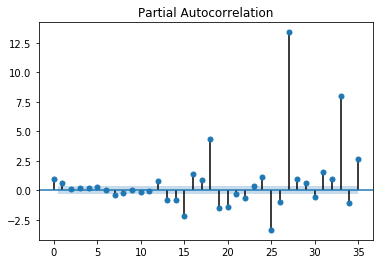

In [375]:
# let's check the partial autocorrelation over a period of 48 months
from statsmodels.graphics.tsaplots import plot_pacf

series = df2
plot_pacf(series, lags=48)
pyplot.show()

In [ ]:
# observation: series is correlated
# the Autocorrelation function for the AR(k) time series is  strong to a lag of k( around 1) and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

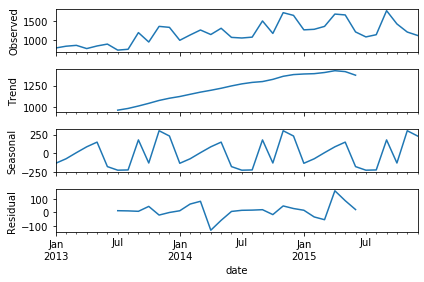

In [376]:
#let decompose the model to series to see if seasonality, trends, noise
from statsmodels.tsa.seasonal import seasonal_decompose
series = df2['sales']
result = seasonal_decompose(series, model='additive')
result.plot()
pyplot.show()


In [ ]:
#observation; the sales are pretty steady thourghout the year except but has some peaks
# there is no seasonality but there seems to be a trend

In [321]:
# checking for stationarity by running the dickey-fuller test.
# if p static less than critical value then data is stationnary

from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(df2['sales'])

Results of Dickey-Fuller Test:
Test Statistic                -8.498983e+00
p-value                        1.253221e-13
#Lags Used                     6.000000e+00
Number of Observations Used    1.067000e+03
Critical Value (1%)           -3.436493e+00
Critical Value (5%)           -2.864253e+00
Critical Value (10%)          -2.568214e+00
dtype: float64


In [ ]:
# P test statistic is less than the critical value, so the series is stationary


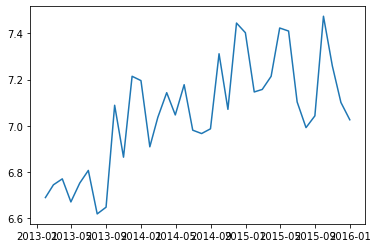

In [387]:
# let fix the trend by elimination using Log
df2_log=  np.log(df2)
plt.plot(df2_log)
# didn't do much !

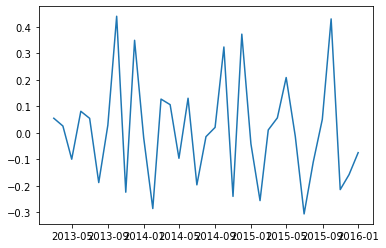

In [386]:
# let's try the differentiating technic
df2_log_diff = df2_log - df2_log.shift()
plt.plot(df2_log_diff)
# observation : it works!  the trends was reduced significantly

In [402]:
# checking if the differentiating series has null or Nan
df2_log_diff['sales'] = df2_log_diff['sales'].fillna(0)
df2_log_diff[df2_log_diff['sales'].isin([np.nan, np.inf, -np.inf])]

,sales
date,


Model performance DRAFT(to be adjusted once part 3 is submitted)
using a ARIMA model ARIMA, short for ‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

We will focus on the Sales forecast for the performance

In [408]:
#let estimate my P,d, q values for arima
#p= is num of lag obser,  d=num of time that of the raw obs are differentiated, 
# q is the size of moving average
#%pip install pmdarima
import pmdarima as pm
from pmdarima.arima.utils import ndiffs


#y = df2.sales
y=df2_log_diff.sales


## Adf Test
print(ndiffs(y, test='adf') ) # 1

# KPSS test
print(ndiffs(y, test='kpss'))  # 1

# PP test:
print(ndiffs(y, test='pp'))  # 0

0
0
0


In [409]:
# from that we know that our best ARIMA parameters are 0,1,0 so we can fit the data into it
from statsmodels.tsa.arima_model import ARIMA
from pandas import Series


#  ARIMA Model fit
ts_log_diff.dropna(inplace=True)
model = ARIMA(df2_log_diff, order=(0,0,0))
model_fit = model.fit(disp=1)
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  sales   No. Observations:                   36
Model:                     ARMA(0, 0)   Log Likelihood                   7.524
Method:                           css   S.D. of innovations              0.196
Date:                Sun, 08 Dec 2019   AIC                            -11.047
Time:                        01:13:15   BIC                             -7.880
Sample:                    01-31-2013   HQIC                            -9.942
                         - 12-31-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0093      0.033      0.286      0.777      -0.055       0.073
==============================================================================
"""

In [ ]:
#observation:  there is no AR values which means that the series is stationnary

In [404]:

#  ARIMA Model with a different order to see different values of error and stdv at different lags
model = ARIMA(df2_log_diff, order=(5,1,0))
model_fit = model.fit(disp=0)
model_fit.summary()
#summary(model_fit)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                   9.543
Method:                       css-mle   S.D. of innovations              0.176
Date:                Sun, 08 Dec 2019   AIC                             -5.086
Time:                        00:58:54   BIC                              5.801
Sample:                    02-28-2013   HQIC                            -1.328
                         - 12-31-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0008      0.005     -0.154      0.879      -0.011       0.009
ar.L1.D.sales    -1.2299      0.141     -8.731      0.000      -1.506      -0.954
ar.L2.D.sales    -1.2720      0.199     -6.382      0.000      -1.663      -0.881
ar.L3.D.sales    -1.1497      0.223     -5.160      0.000      -1.586      -0.713
ar.L4.D.sales    -0.9472      0.193     -4.900      0.000      -1.326      -0.568
ar.L5.D.sales    -0.5275      0.138     -3.816      0.001      -0.798      -0.257
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3828           -1.0286j            1.0976           -0.1933
AR.2            0.3828           +1.0286j            1.0976            0.1933
AR.3           -0.6757           -0.9189j            1.1406           -0.3509
AR.4           -0.6757           +0.9189j            1.1406            0.3509
AR.5           -1.2098           -0.0000j            1.2098           -0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
# observation: P value is 0.87 which is more than our significance level of 0.05


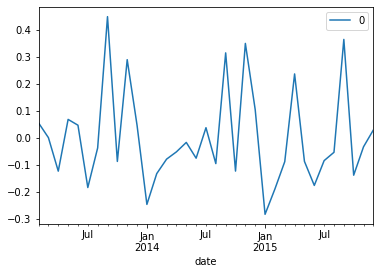

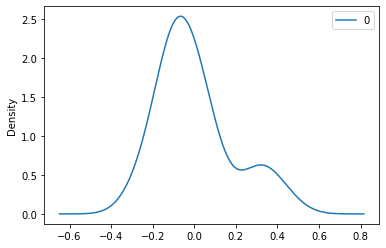

               0
count  35.000000
mean    0.000868
std     0.179014
min    -0.282602
25%    -0.108600
50%    -0.051177
75%     0.051709
max     0.449651


In [405]:
# let check our Model residual error
# plot residual errors

from pandas import DataFrame
from matplotlib import pyplot
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())




In [ ]:
#the residual errors is centered near zero mean and uniform variance.
# good sign for the model

In [406]:

# Performance evaluation

# let evaluate the model performance with  trained data
# we we will also use a 70% of the data training
## we will use 70% of the whole data for training and the remaining 30 % for test

########
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 

 

X = df2_log_diff.values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
#pyplot.plot(test)
#pyplot.plot(predictions, color='red')
#pyplot.show()


predicted=-0.137569, expected=0.010921
predicted=-0.164371, expected=0.056634
predicted=0.030017, expected=0.209101
predicted=0.124749, expected=-0.013180
predicted=0.126043, expected=-0.306691
predicted=-0.148485, expected=-0.111056
predicted=-0.236472, expected=0.050934
predicted=-0.042239, expected=0.430826
predicted=0.238915, expected=-0.214718
predicted=0.166401, expected=-0.158071
predicted=-0.197473, expected=-0.074990
Test MSE: 0.086


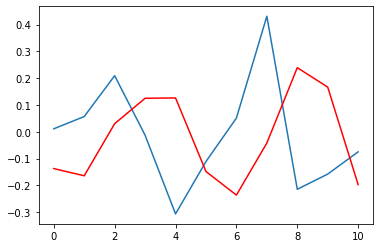

In [407]:
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


In [421]:
mape = np.mean(np.abs(predictions - test)/np.abs(test))
print ('the mape  is: %1.3f' % mape)      
print ('Standard error of the prediction: %1.3f' % mape)
mpe = np.mean((predictions - test)/test) 
print('the mpe is: %1.3f' % mpe)
rmse = np.mean((predictions - test)**2)**.5  
print('the RMSE is: %1.3f' % rmse)

the mape  is: 3.919
Standard error of the prediction: 3.919
the mpe is: -3.561
the RMSE is: 0.293


-overall the predicted values are pretty closed to the training 
-the graph of test vs predictions shows that the forecast mimics the test but the model parameters might need some adjustment for both curve to closer
-MSE implies on average the model was wrong 8.6% of the times
-mape at 3.19% implies that our model is 96.09% accurate
RMSE 0.293 is closed to O errors.

explanation of the whole process and conclusion

first we prepared the data to be fitted to our model

during the preparation, a stationarity( seasonality) was rules out by both the dickey-fuller test and decompose graph. However, a trend was noticed with the decomposed plot.
in order to eliminate the trend a differenciating technic was used.  it's worth noting that without log function technic was used at first but was giving an overfitting model( large number of RMSE) and without either technic, the rmse was even larger. in other word the model needs the series to be stationnary
the model used was ARIMA with the parameter 1, 1,0.  With the Arima model, we were able to achieve a prediction with 96.06% accuracy.It's worth noting that with the transformed/differentiated data the best fit arima model has the parameter 0,0,0 which wasn't given much information during lag. 

conclusion: the Arima time series models use information coming from the time series itself like the observed values. However the  model may not be able to see and to model high and low peaks. Also the model assumes the series is stationnary; mean, variance, and autocorrelation should be approximately constant through time